In [1]:
from scipy import spatial
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
from swifter import swifter

sns.set_theme()

In [2]:
data = pd.read_csv('../../../data/data_with_weather.csv', sep=',')
data = data[['lat','lon','timestamps_UTC','mapped_veh_id']]
data['timestamps_UTC'] = pd.to_datetime(data.timestamps_UTC)
data['mapped_veh_id'] = data.mapped_veh_id.apply(lambda x: str(int(x)))
#data['journey'] = data['mapped_veh_id']+'#'+data['timestamps_UTC'].dt.strftime('%y-%m-%d')
data.head()

,lat,lon,timestamps_UTC,mapped_veh_id
0,50.769818,3.872114,2023-08-01 03:44:12,181
1,51.039993,3.693429,2023-08-01 06:36:29,143
2,50.742203,3.602035,2023-08-24 06:53:54,183
3,50.930914,5.327132,2023-08-01 13:53:38,177
4,51.180773,3.575259,2023-08-24 07:02:30,143


In [3]:
geo_data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.lon, data.lat), crs="EPSG:4326"
)

geo_data['geometry'] = geo_data.geometry.to_crs("EPSG:3857")

In [4]:
geo_data['x'] = geo_data.geometry.apply(lambda x : x.x)
geo_data['y'] = geo_data.geometry.apply(lambda x : x.y)
geo_data.head()

,lat,lon,timestamps_UTC,mapped_veh_id,geometry,x,y
0,50.769818,3.872114,2023-08-01 03:44:12,181,POINT (431041.803 6580677.803),431041.803301,6.580678e+06
1,51.039993,3.693429,2023-08-01 06:36:29,143,POINT (411150.580 6628371.143),411150.579901,6.628371e+06
2,50.742203,3.602035,2023-08-24 06:53:54,183,POINT (400976.669 6575818.415),400976.668624,6.575818e+06
3,50.930914,5.327132,2023-08-01 13:53:38,177,POINT (593013.599 6609082.348),593013.599365,6.609082e+06
4,51.180773,3.575259,2023-08-24 07:02:30,143,POINT (397995.967 6653332.794),397995.966806,6.653333e+06


In [5]:
df = geo_data[['x','y']]
df.values

array([[ 431041.8033013 , 6580677.8029202 ],
       [ 411150.57990136, 6628371.14345532],
       [ 400976.6686237 , 6575818.41512385],
       ...,
       [ 420266.24357175, 6624068.93447607],
       [ 568773.62439713, 6654898.14431451],
       [ 410095.09301746, 6628580.78046588]])

In [6]:
del data
del geo_data

In [7]:
kdtree = spatial.KDTree(df.values)
distance,index = kdtree.query([ 431041.8033013 , 6580677.8029202 ], k = 20)
np.average(distance[1:])

0.3330657200451262

In [8]:
%%time
# get avg distance to 10 nearest neighbours
def get_dist(row):
    distance, _ = kdtree.query([row.x,row.y], k = 5)
    return np.average(distance[1:])

df['dist'] = df.apply(get_dist,axis =1)
df.head()

CPU times: user 10min 17s, sys: 1.06 s, total: 10min 18s
Wall time: 19min 46s


,x,y,dist
0,431041.803301,6.580678e+06,0.152585
1,411150.579901,6.628371e+06,0.048538
2,400976.668624,6.575818e+06,0.040165
3,593013.599365,6.609082e+06,0.141274
4,397995.966806,6.653333e+06,0.121878


<Axes: xlabel='dist', ylabel='Count'>

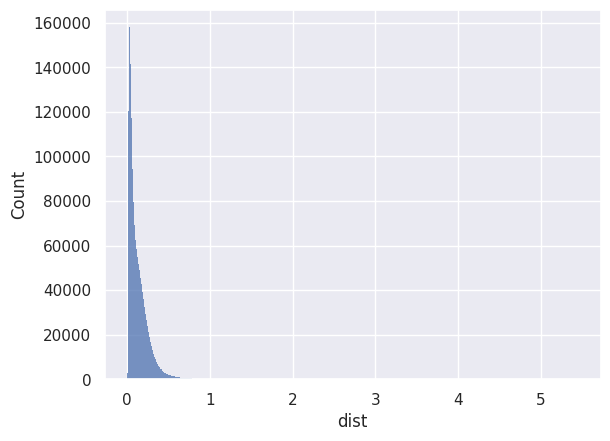

In [9]:
sns.histplot(np.log10(df+1), x = 'dist')

<Axes: xlabel='dist'>

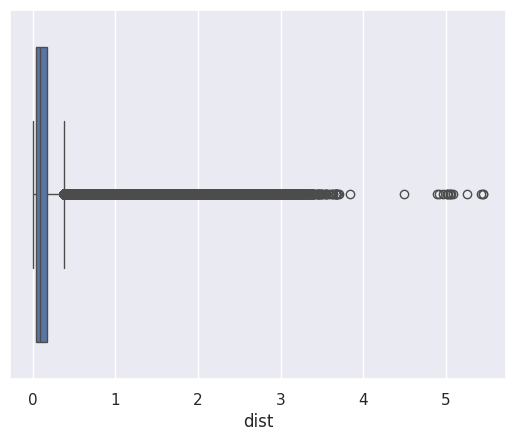

In [10]:
sns.boxplot(np.log10(df+1), x = 'dist')

In [11]:
np.sum(df['dist']>10) #0.13%

22202

In [12]:
np.sum(df['dist']>500) #0.003%

622

In [13]:
np.sum(df['dist']>1000) #0.001

302

In [29]:
np.sum(df['dist']>3000) #0.001

39

In [14]:
np.sum(df['dist']>10000)

15

In [15]:
df.sort_values('dist', ascending = False).head(50)

,x,y,dist
8953244,610490.169426,6.156187e+06,282421.342862
2929855,499328.151184,6.956601e+06,281989.890121
8972089,895620.061489,6.447822e+06,263883.801642
14485639,731645.394016,6.399569e+06,179015.755580
9624290,275449.226318,6.682287e+06,121252.227930
377873,411908.287147,6.340201e+06,113358.990999
12241898,217522.359303,6.546224e+06,111406.918167
17612420,218273.854922,6.548979e+06,109998.764613
4484586,19486.376676,6.503628e+06,106022.228710
3213259,23020.069196,6.515474e+06,103622.990367


<Axes: xlabel='dist', ylabel='Count'>

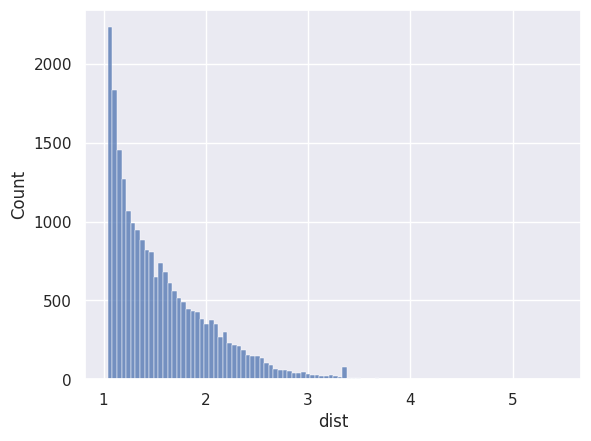

In [16]:
sns.histplot(np.log10(df[df.dist>10]+1), x = 'dist')

<Axes: xlabel='x', ylabel='y'>

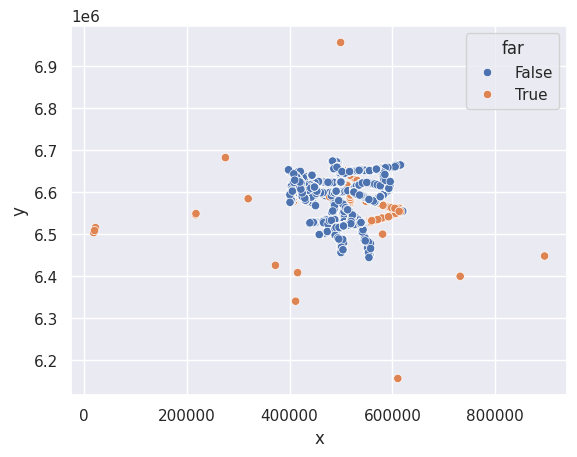

In [22]:
df['far'] = df['dist']>1000
sns.scatterplot(data = df,x ='x', y ='y', hue = 'far')

<Axes: xlabel='x', ylabel='y'>

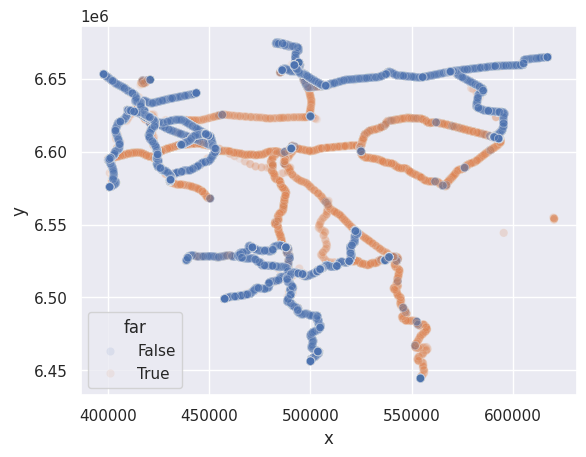

In [18]:
df['far'] = df['dist']>10
sns.scatterplot(data = df[df['dist']<1000],x ='x', y ='y', hue = 'far', alpha = 0.1)

<Axes: xlabel='x', ylabel='y'>

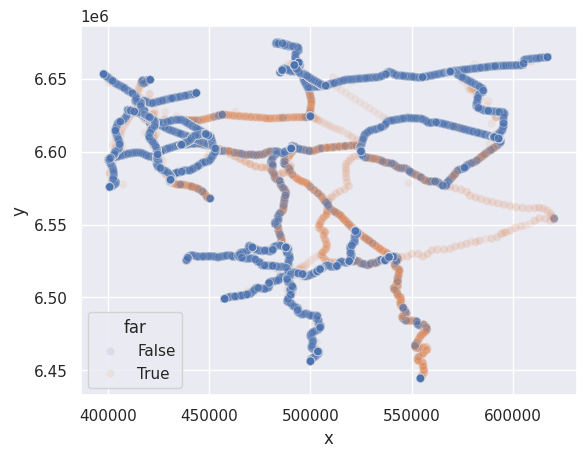

In [19]:
df['far'] = df['dist']>100
sns.scatterplot(data = df[df['dist']<10000],x ='x', y ='y', hue = 'far', alpha = 0.1)

<Axes: xlabel='x', ylabel='y'>

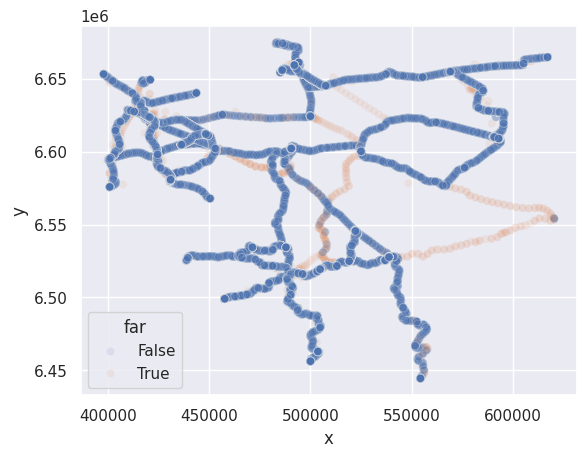

In [20]:
df['far'] = df['dist']>500
sns.scatterplot(data = df[df['dist']<10000],x ='x', y ='y', hue = 'far', alpha = 0.1)

<Axes: xlabel='x', ylabel='y'>

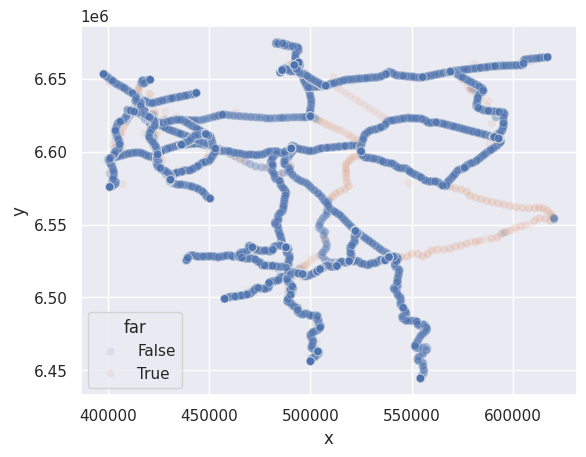

In [21]:
df['far'] = df['dist']>1000
sns.scatterplot(data = df[df['dist']<10000],x ='x', y ='y', hue = 'far', alpha = 0.1)

<Axes: xlabel='x', ylabel='y'>

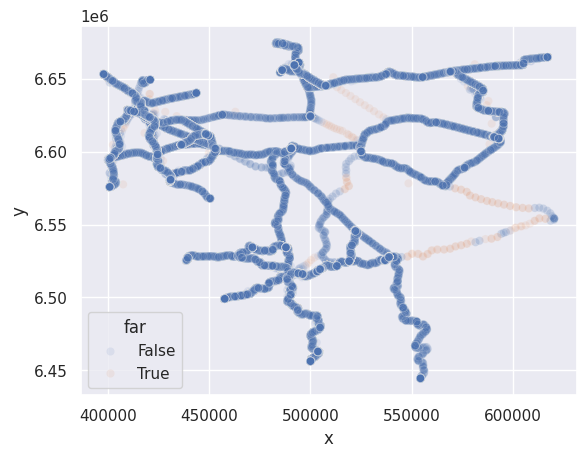

In [25]:
df['far'] = df['dist']>2000
sns.scatterplot(data = df[df['dist']<10000],x ='x', y ='y', hue = 'far', alpha = 0.1)

<Axes: xlabel='x', ylabel='y'>

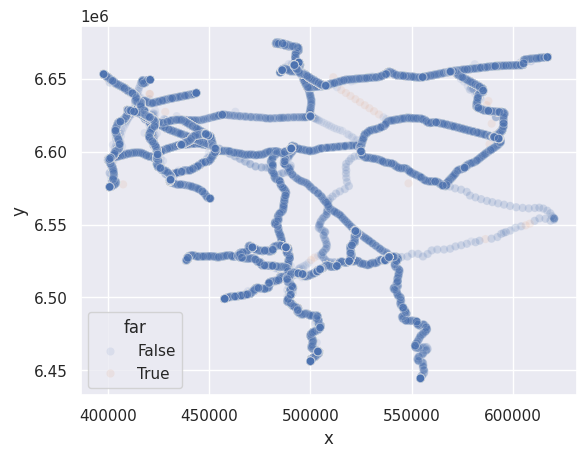

In [30]:
df['far'] = df['dist']>3000
sns.scatterplot(data = df[df['dist']<10000],x ='x', y ='y', hue = 'far', alpha = 0.1)

In [ ]:
df['dist']>3000